In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

import shutil, os, sys, io, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tensor_board_logger import TensorBoardLogger
from layer_visualizer import LayerVisualizer
from tqdm import tqdm 

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
KTF.set_session(session)

In [2]:
class GAN():
    def __init__(self):
        # ---------------------
        #  for log on TensorBoard
        # ---------------------   
        target_dir = './my_log_dir'
        shutil.rmtree(target_dir, ignore_errors=True)
        os.mkdir(target_dir)
        self.logger = TensorBoardLogger(log_dir=target_dir)

        # ---------------------
        #  Parameter
        # ---------------------
        self.unrolling_steps = 5
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100 # Noiseの次元
        optimizer = Adam(0.0002, 0.5)

        # ---------------------
        #  Build and compile the discriminator
        # ---------------------        
        self.discriminator = self.build_discriminator()
        self.discriminator.trainable = True       
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy']
                                  )

        # ---------------------
        #  Build and compile the combined model
        # ---------------------
        # Build the generator
        self.generator = self.build_generator()

        # Instantiate the combined model
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        validity = self.discriminator(img)
        self.combined = Model(z, validity)
              
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        # Compile the combined model
        self.combined.compile(loss='binary_crossentropy', 
                              optimizer=optimizer, metrics=['accuracy']
                             )
        
    def build_generator(self):
        model = Sequential()  
        model.add(Dense(100, input_dim=self.latent_dim))
        model.add(Reshape((10, 10, -1)))
        model.add(Conv2DTranspose(128, (5, 5), strides=1, padding='valid'))
        model.add(Conv2DTranspose(128, (2, 2), strides=1, padding='same'))
        model.add(Conv2DTranspose(128, (2, 2), strides=1, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(AveragePooling2D((2, 2), strides=1, padding='same'))
        model.add(Conv2DTranspose(64, (2, 2), strides=2, padding='valid'))
        model.add(Conv2DTranspose(64, (2, 2), strides=1, padding='same'))
        model.add(Conv2DTranspose(1, (2, 2), strides=1, padding='same'))
        model.add(Dense(1, activation='tanh')) # activation='tanh'なので-1,1の範囲の値を持つ。
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        # model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, sample_interval=50):     
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3) # Insert a new axis.

        # Adversarial ground truths
        valid_1 = np.ones((batch_size, 1))
        fake_0 = np.zeros((batch_size, 1))
        valid = (1.2 - 0.7) * np.random.rand(batch_size, 1) + 0.7
        fake = (0.3 - 0.0) * np.random.rand(batch_size, 1) + 0.0
        
        for epoch in tqdm(range(epochs+1)):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            # Generate a batch of new images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # Generate a batch of new images            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid) # 単一バッチデータにつき一度の勾配更新を行う。
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Unrolling Process 1 (Train discriminator unrolling_step times)
            # --------------------- 
            if self.unrolling_steps != 0:
                # Backup weights
                backup_weights = self.discriminator.get_weights()
                
                # Unrolling 
                for _ in range(self.unrolling_steps):
                    # Generate a batch of new images
                    idx = np.random.randint(0, X_train.shape[0], batch_size)
                    imgs = X_train[idx]

                    # Generate a batch of new images            
                    noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                    gen_imgs = self.generator.predict(noise)

                    # Train the discriminator
                    d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                    d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)           

            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid_1)        

            # ---------------------
            #  Unrolling Process 2 (Unbdo weights)
            # --------------------- 
            if self.unrolling_steps != 0:
                # Undo waights
                self.discriminator.set_weights(backup_weights)

            # ---------------------
            #  Log on TensorBoard
            # ---------------------
            logs = {'Discriminator/loss': d_loss[0], 'Generator/loss': g_loss[0], 'Generator/acc': g_loss[1]}
            histograms = {}
            for layer in self.generator.layers[1].layers:
                for i in range(len(layer.get_weights())):
                    if 'conv' in layer.name or 'dense' in layer.name:
                        name = layer.name + '/' + str(i)
                        value = layer.get_weights()[i]
                        histograms[name] = value
            self.logger.log(logs=logs, histograms=histograms, epoch=epoch)
            
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                fig, name = self.sample_images(epoch)
                images = {name: fig}
                self.logger.log(images=images, epoch=epoch)
                print ("%d [D loss: %f] [G loss: %f, G acc.: %.2f%%]" % (epoch, d_loss[0], g_loss[0], 100*g_loss[1]))

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        name = str(epoch) + '.png'
        return fig, name
        # fig.savefig("images/%d.png" % epoch)
        # plt.close()

In [3]:
gan = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 10, 1)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       3328      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 128)       65664     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 128)       65664     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
__________

  0%|          | 0/30001 [00:00<?, ?it/s]/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|          | 2/30001 [00:11<68:46:38,  8.25s/it]

0 [D loss: 0.768825] [G loss: 0.810691, G acc.: 15.62%]


 17%|█▋        | 5002/30001 [09:04<1:12:32,  5.74it/s]

5000 [D loss: 0.465736] [G loss: 1.254175, G acc.: 15.62%]


 33%|███▎      | 10002/30001 [17:43<52:01,  6.41it/s]

10000 [D loss: 0.412373] [G loss: 1.680434, G acc.: 9.38%]


 50%|█████     | 15002/30001 [26:33<54:34,  4.58it/s]  

15000 [D loss: 0.447063] [G loss: 1.472909, G acc.: 21.88%]


 67%|██████▋   | 20002/30001 [35:06<42:46,  3.90it/s]

20000 [D loss: 0.437724] [G loss: 1.763334, G acc.: 12.50%]


 83%|████████▎ | 25002/30001 [43:33<14:44,  5.65it/s]

25000 [D loss: 0.424492] [G loss: 1.678206, G acc.: 3.12%]


100%|██████████| 30001/30001 [51:55<00:00,  9.63it/s]

30000 [D loss: 0.457953] [G loss: 1.595121, G acc.: 6.25%]


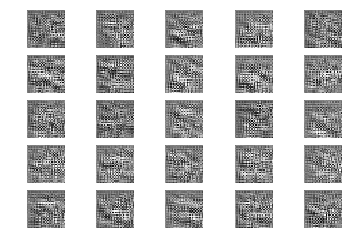

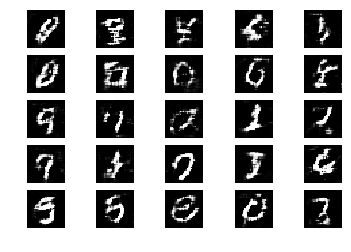

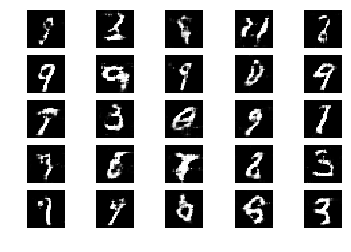

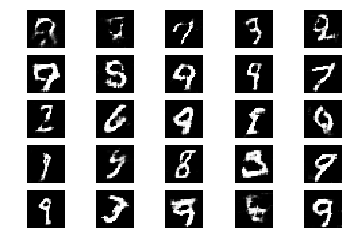

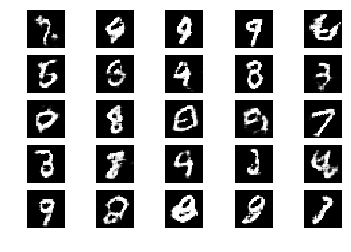

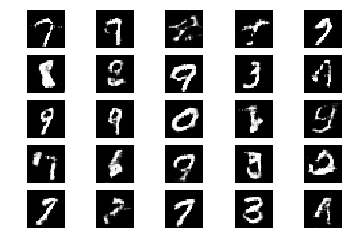

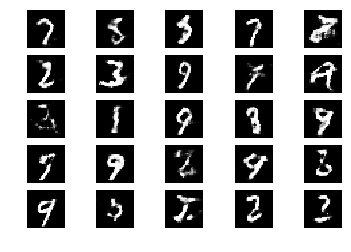

In [4]:
gan.train(epochs=30000, batch_size=32, sample_interval=5000)

In [51]:
model = gan.generator.layers[1]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 100)               10100     
_________________________________________________________________
reshape_10 (Reshape)         (None, 10, 10, 1)         0         
_________________________________________________________________
conv2d_transpose_91 (Conv2DT (None, 14, 14, 128)       3328      
_________________________________________________________________
conv2d_transpose_92 (Conv2DT (None, 14, 14, 128)       65664     
_________________________________________________________________
conv2d_transpose_93 (Conv2DT (None, 14, 14, 128)       65664     
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 14, 14, 128)       512       
__________

conv2d_transpose_91


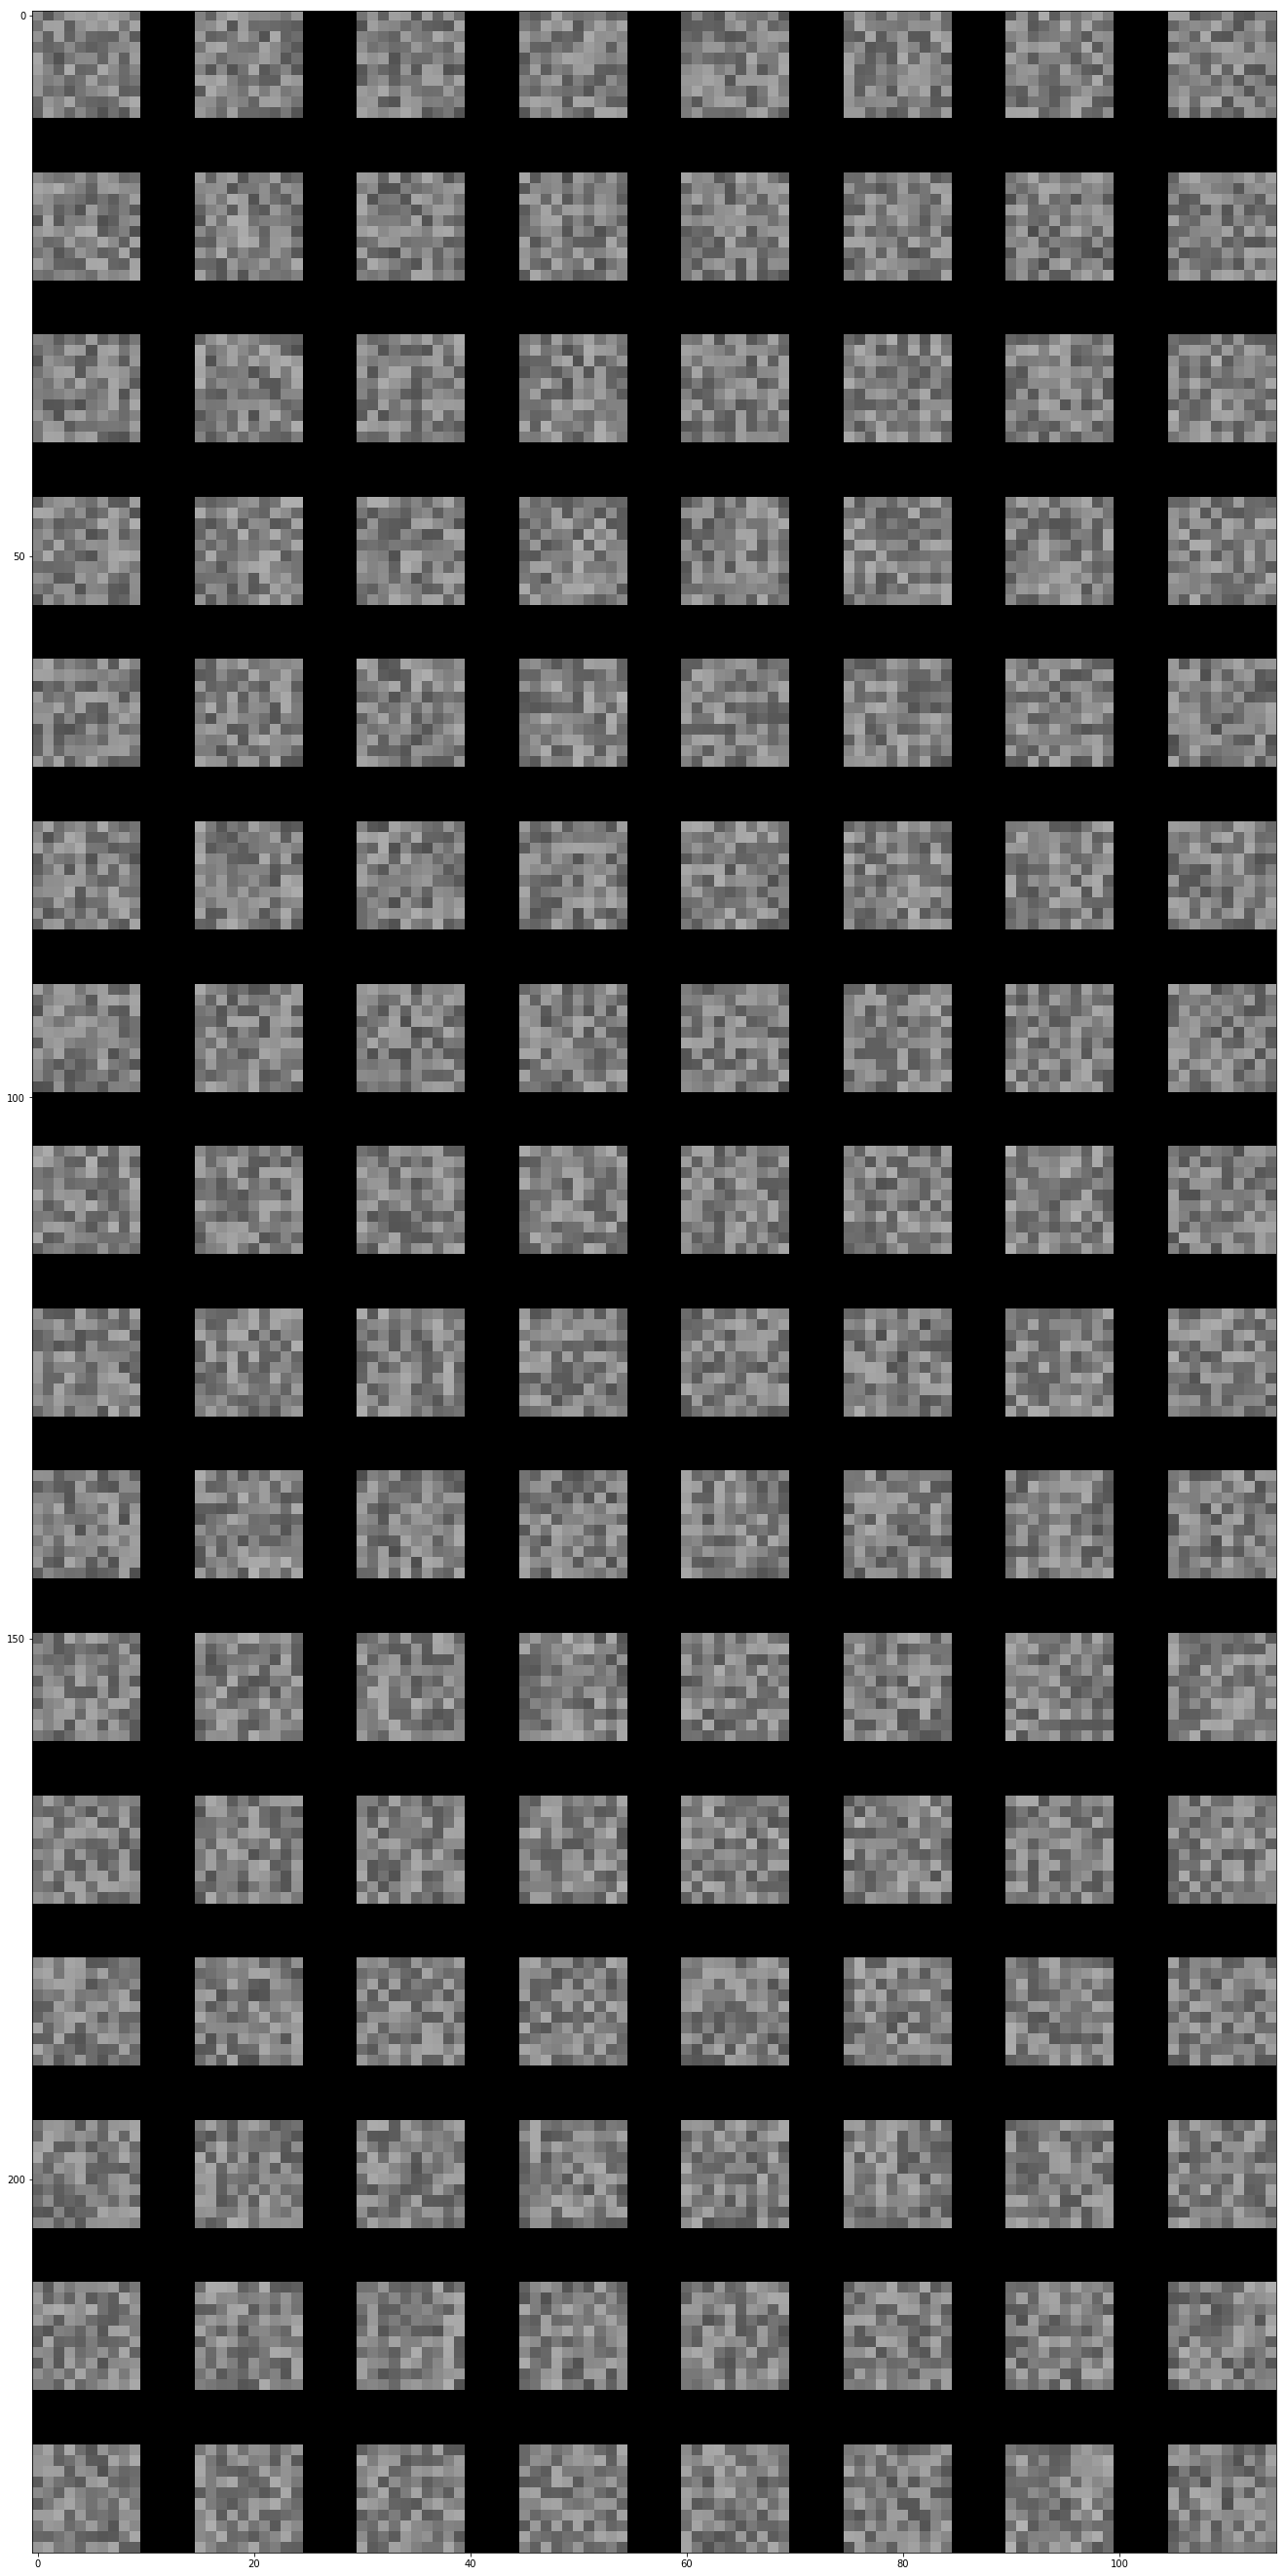

conv2d_transpose_92


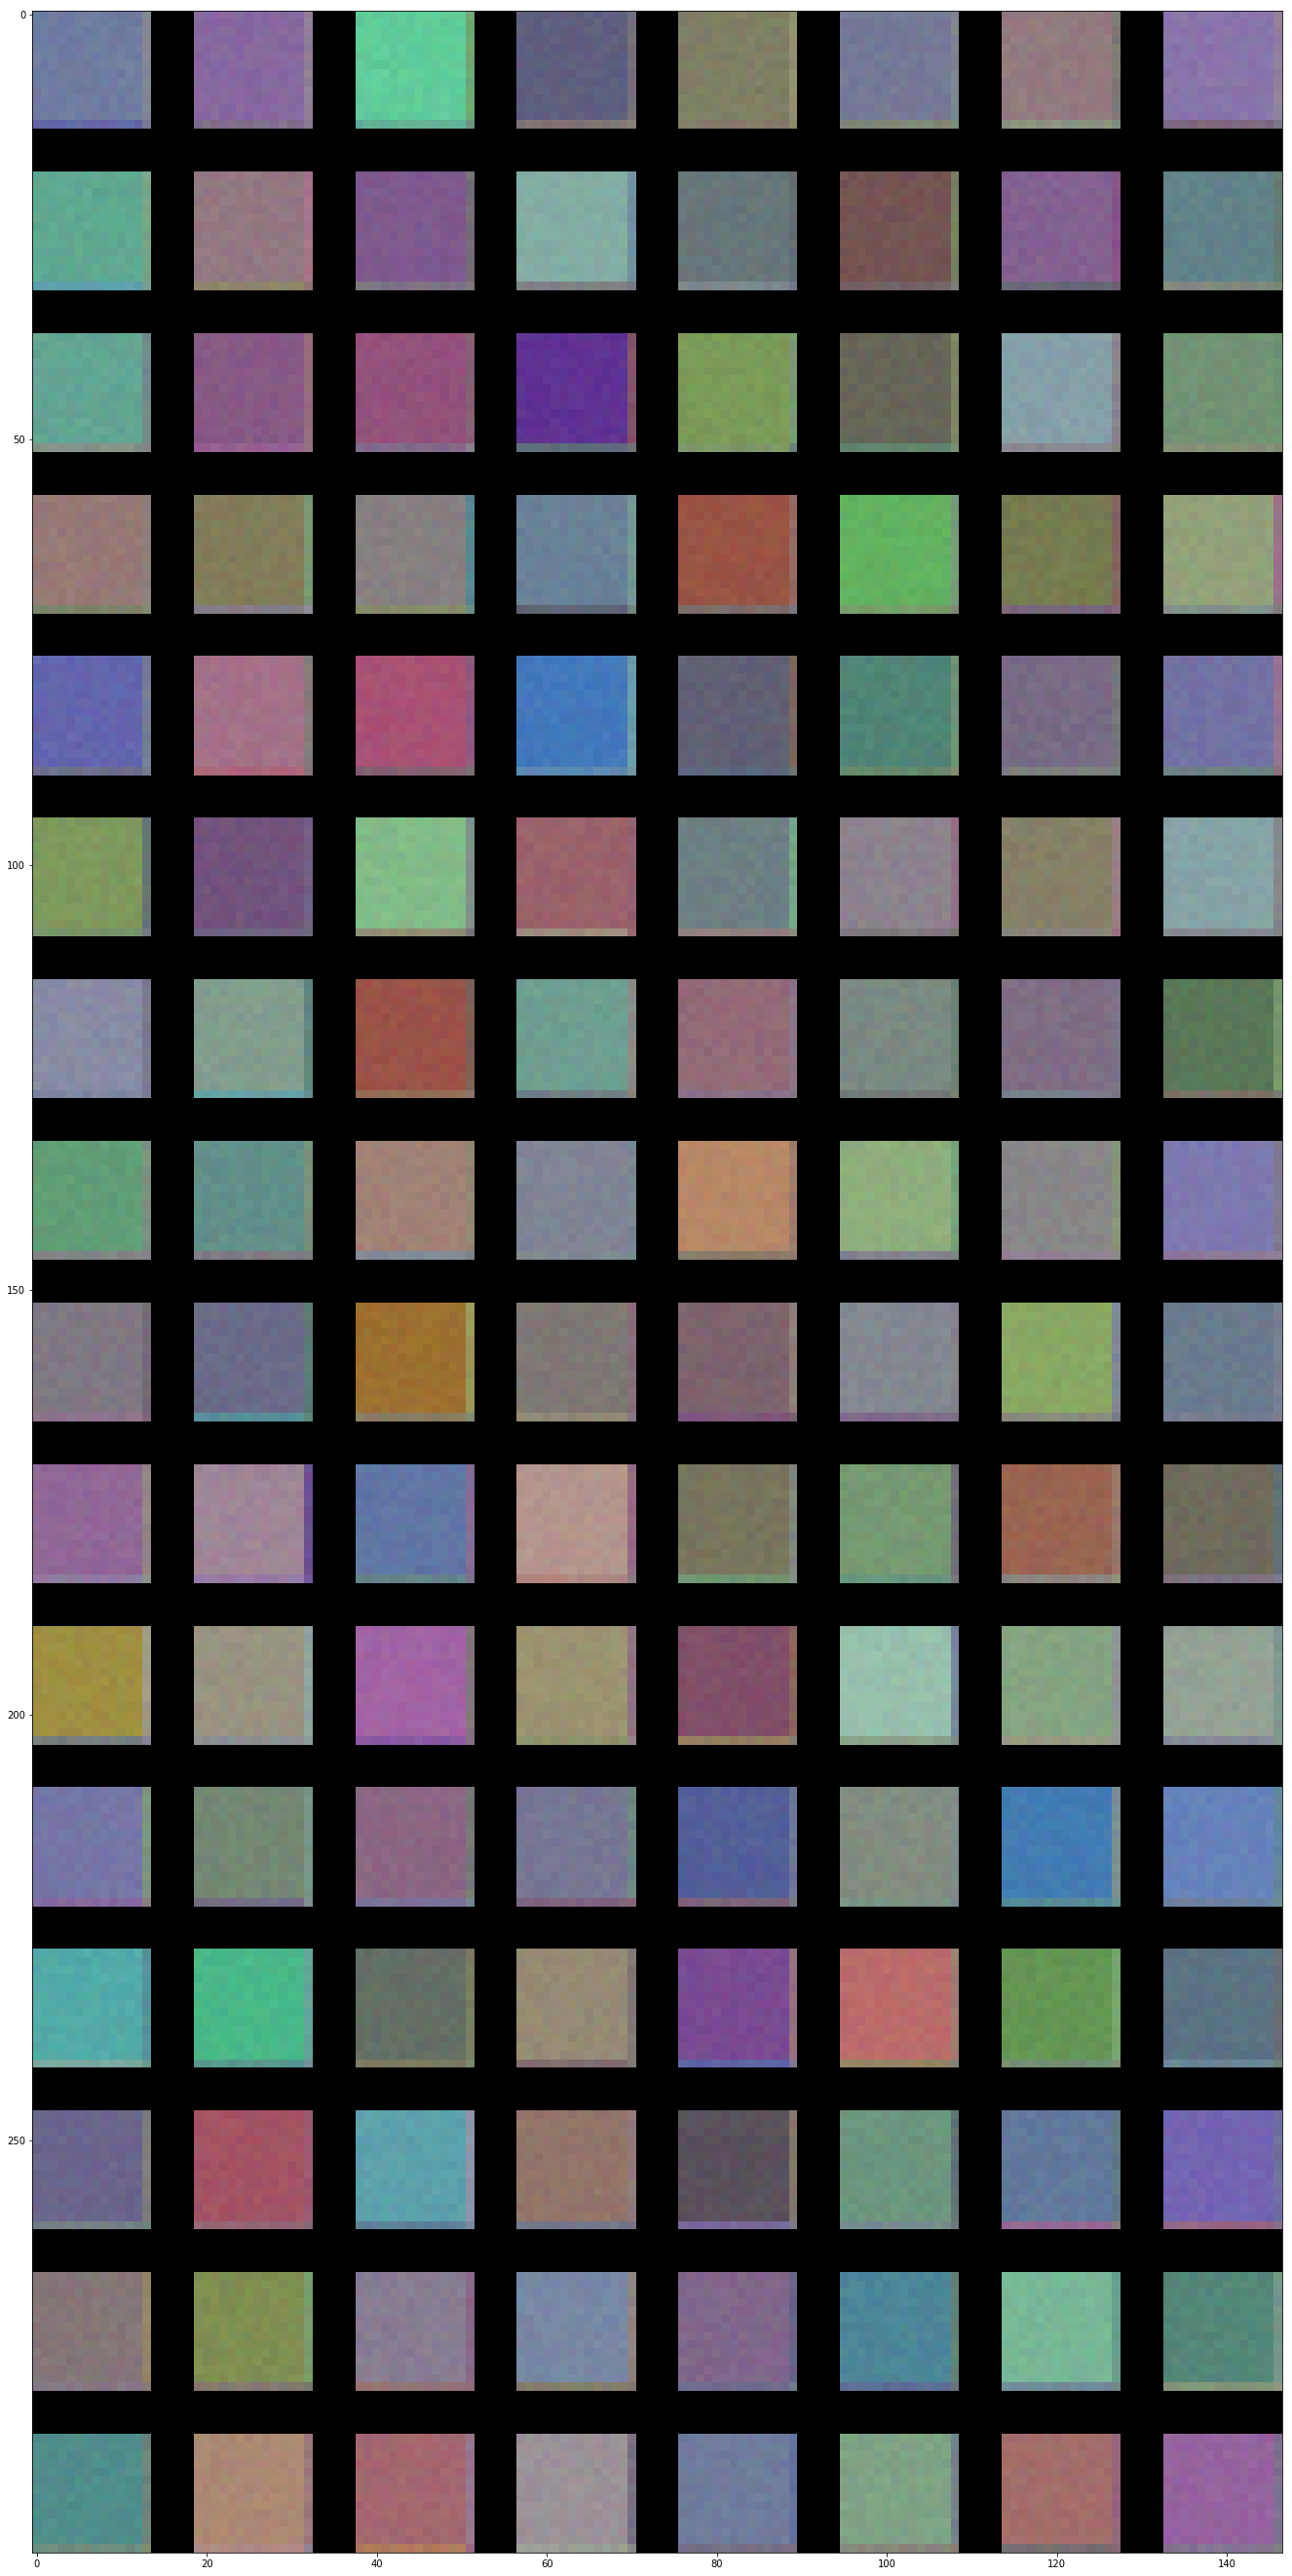

conv2d_transpose_93


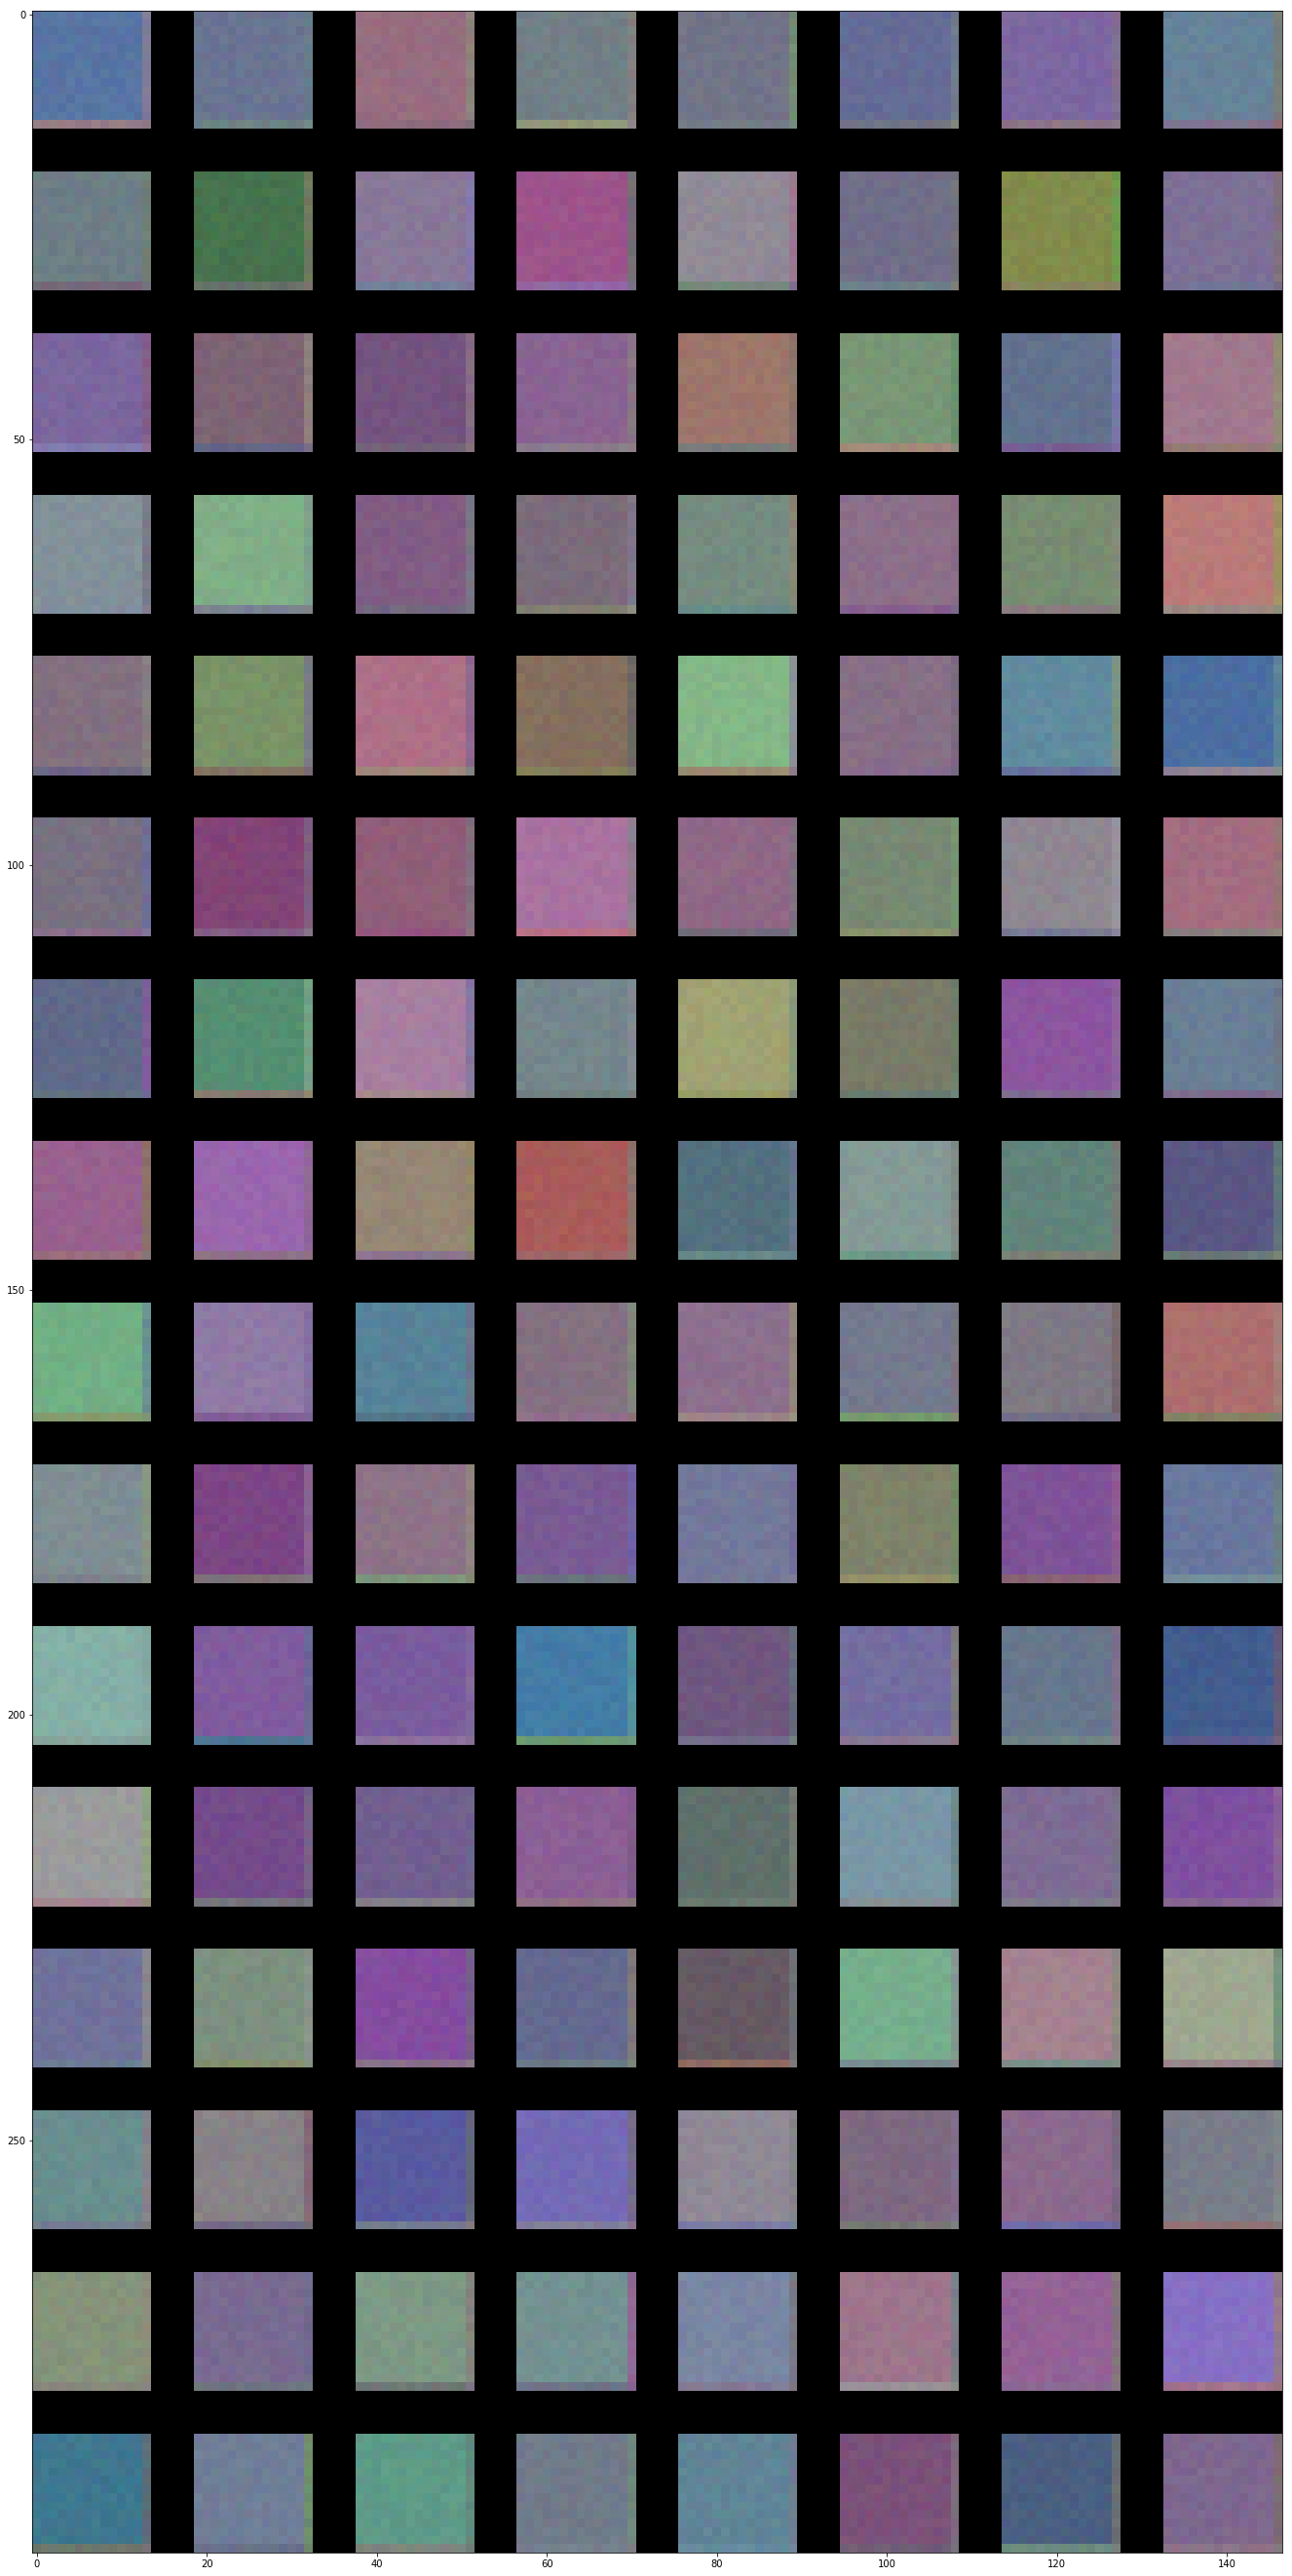

conv2d_transpose_94


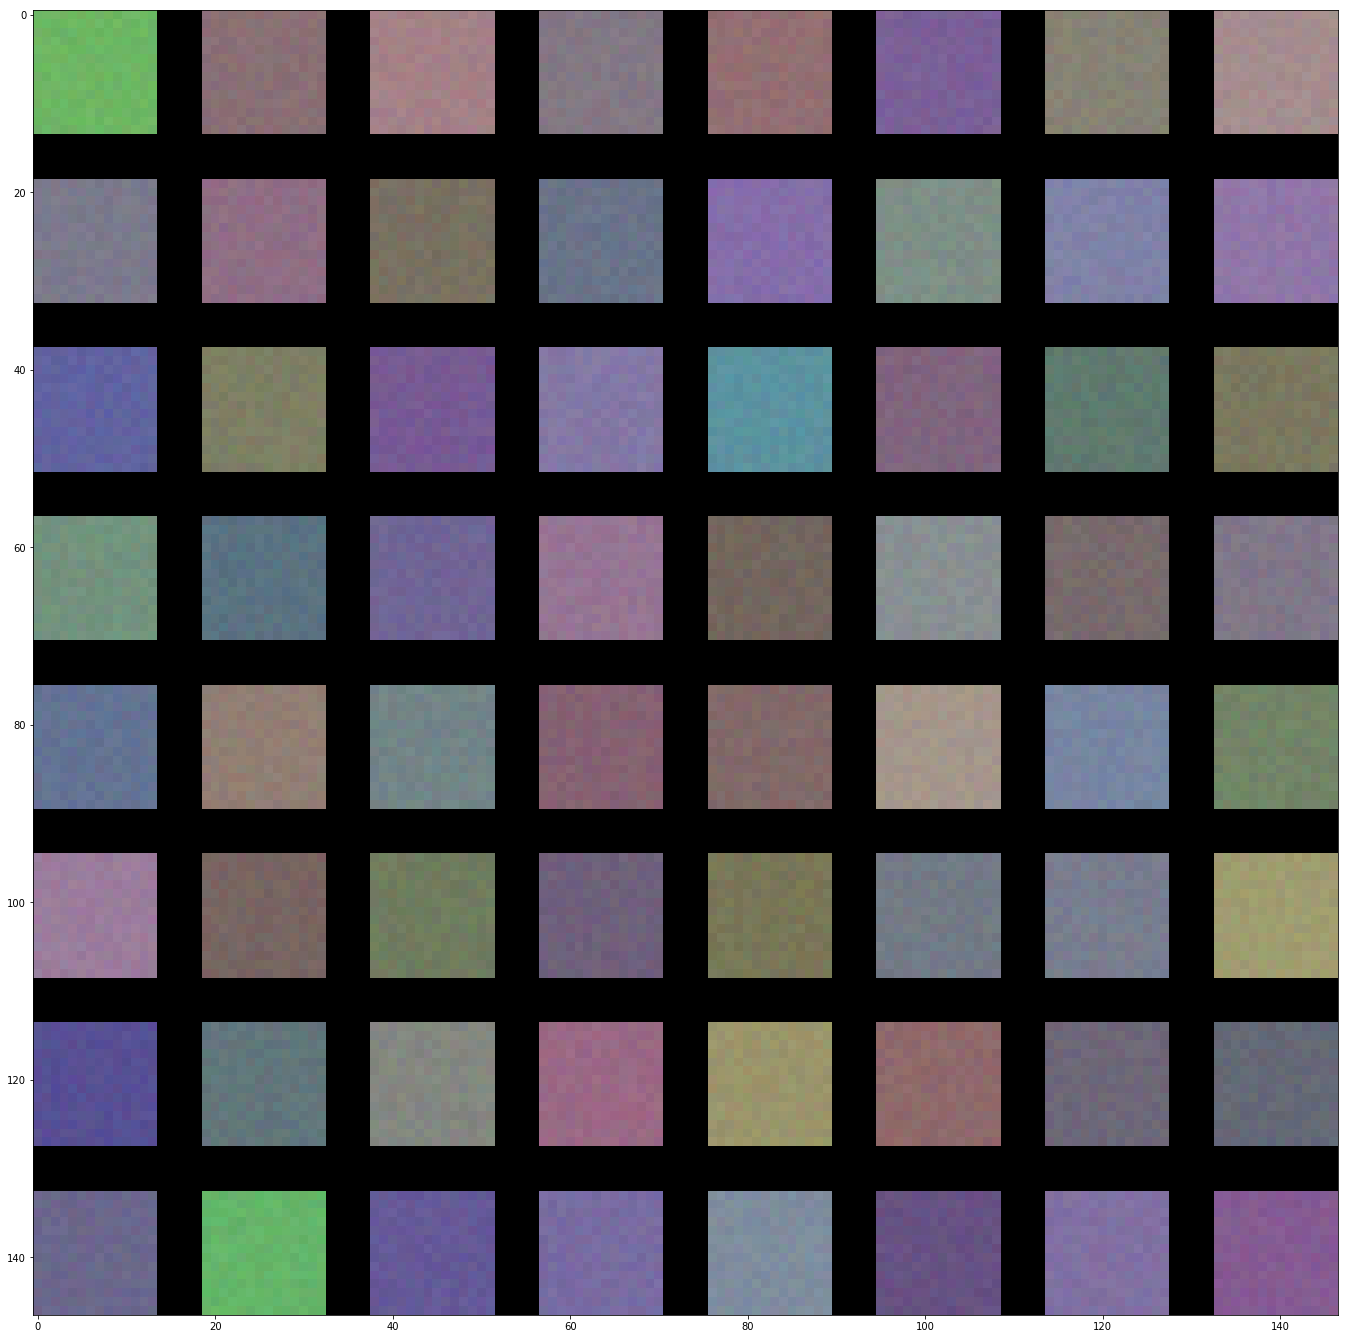

conv2d_transpose_95


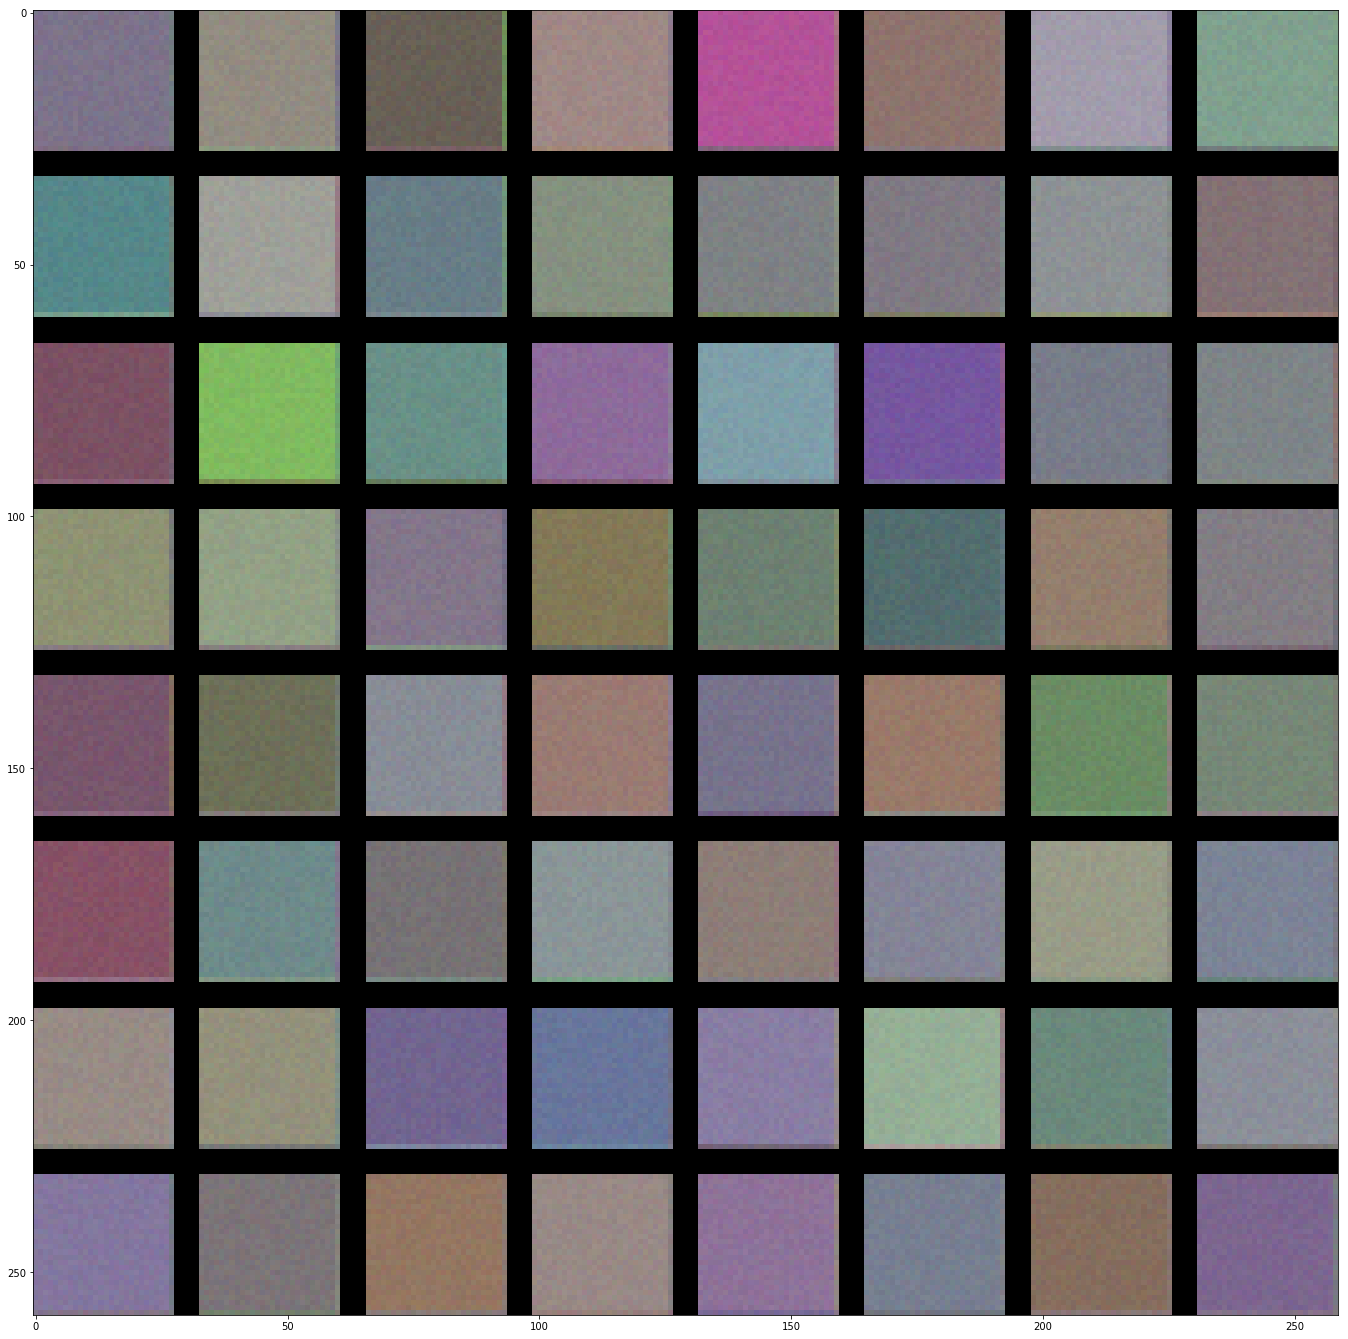

conv2d_transpose_96


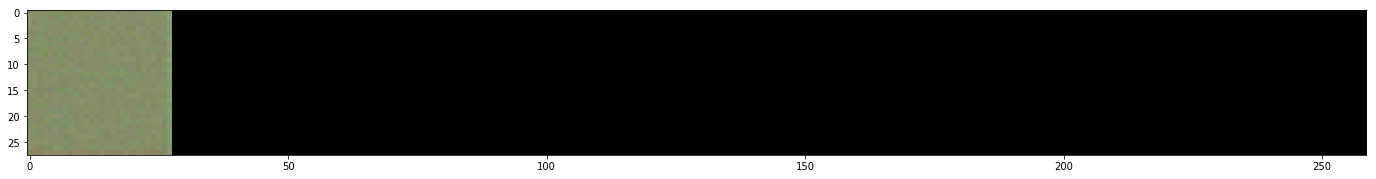

In [52]:
for layer_name in ['conv2d_transpose_91', 'conv2d_transpose_92', 'conv2d_transpose_93', 'conv2d_transpose_94', 'conv2d_transpose_95', 'conv2d_transpose_96']:
    LayerVisualizer(model, layer_name)